In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import random

import math
import time

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import StrMethodFormatter
from matplotlib.ticker import ScalarFormatter


In [2]:
# Define Tableau 10 Colors
tableau_colors = [
    (31, 119, 180),  # Blue 0
    (255, 127, 14),  # Orange 1
    (44, 160, 44),   # Green 2
    (214, 39, 40),   # Red 3
    (148, 103, 189), # Purple 4 
    (140, 86, 75),   # Brown 5
    (227, 119, 194), # Pink 6
    (127, 127, 127), # Gray 7
    (188, 189, 34),  # Yellow 8
    (23, 190, 207),  # Cyan 9
]

# Normalize RGB values to range [0, 1]
tableau_colors = [(r / 255, g / 255, b / 255) for r, g, b in tableau_colors]

font = {'family': 'Georgia', 'color':  'black', 'weight': 'normal', 'size': 20}
title_font = {'family': 'Georgia', 'color':  'black', 'weight': 'bold', 'style': 'italic', 'size': 20}
suptitle_font = FontProperties(family='Georgia', weight='bold', size=22)
legend_font = FontProperties(family='Georgia', weight='normal', size=16)
tick_font = {'family': 'Georgia', 'size': 18}

## Single-layer Perceptron for Equivalence Logic

In [3]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_deriv(x):
    return np.exp(-x) / (1.0 + np.exp(-x)) ** 2.0
    
def tanh(x):
    return np.tanh(x)

def tanh_deriv(x):
    return 4.0 / (np.exp(x) + np.exp(-x)) ** 2.0

In [4]:
# hyperparameters
n_epochs = 100000 # number of learning epochs
suffices = ['_original','_expand', '_scramble']
transfer_functions = ['sigmoid', 'tanh']
learning_rates = [0.01, 0.1, 1.0, 10, 100]

In [5]:
# training and testing data sets 
# original equivalence
X_train_original = np.array([[0, 0, 1], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
y_train_original = np.array([0, 0, 1, 1])

X_test_original = np.array([[0, 0, 0], [0, 1, 0], [1, 0, 0], [1, 1, 0]])
y_test_original = np.array([0, 0, 1, 1])

# expand on training set by one case, reduce test set by one case
X_train_expand = np.array([[0, 0, 1], [0, 1, 1], [1, 0, 1], [1, 1, 1], [0, 0, 0]])
y_train_expand = np.array([0, 0, 1, 1, 0])
        
X_test_expand = np.array([[0, 1, 0], [1, 0, 0], [1, 1, 0]])
y_test_expand = np.array([0, 1, 1])

# scramble the cases but keep the number of cases the same as original 
X_train_scramble = np.array([[0, 0, 1], [0, 1, 1], [1, 0, 1], [1, 0, 0]])
y_train_scramble = np.array([0, 0, 1, 1])

X_test_scramble = np.array([[0, 0, 0], [0, 1, 0], [1, 1, 1], [1, 1, 0]])
y_test_scramble = np.array([0, 0, 1, 1])


In [6]:
# single-layer perceptron training
def train_perceptron(X_train, y_train, transfer_function='sigmoid', learning_rate=1.0, \
                     epochs=n_epochs):
    """    
    Train a perceptron using a specified transfer function, and learning rate
    
    Parameters:
    - X_train (numpy array): Input training data.
    - y_train (numpy array): Target training data.
    - transfer_function (str): Transfer function for activation.
    - learning_rate (float): Learning rate for weight updates.
    - epochs (int): Number of training epochs.
    
    Returns:
    - weights (numpy array): Trained weights.
    - train_errors (numpy array): Array of training errors averaged over training cases
    during training.
    """
    
    weights = np.random.rand(X_train.shape[1]) 
    train_errors = np.zeros(epochs)
    
    start_time = time.process_time()
    for epoch in range(epochs):
        net_input = np.dot(weights, X_train.T)
        if transfer_function == 'tanh':
            y_pred = tanh(net_input)
            gradient_weights = 2 * np.dot((y_pred - y_train) * tanh_deriv(net_input), X_train) / len(y_train) 
        elif transfer_function == 'sigmoid':
            y_pred = sigmoid(net_input)
            gradient_weights = 2 * np.dot((y_pred - y_train) * sigmoid_deriv(net_input), X_train) / len(y_train) 
        train_error = np.sum((y_train - y_pred) ** 2) / len(y_train)    
        weights += - learning_rate * gradient_weights
        train_errors[epoch] = train_error
    
    end_time = time.process_time()
    train_time = end_time - start_time
    
    return weights, train_errors, train_time


In [7]:
def test_perceptron(X_test, y_test, weights, transfer_function='sigmoid'):
    """    
    Test a perceptron using trained weights, and a specified transfer function
    
    Parameters:
    - X_test (numpy array): Input test data (numpy array).
    - y_test (numpy array): Target test data (numpy array).
    - transfer_function (str): Transfer function for activation.
    
    Returns:
    - y_pred (numpy array): Predicted output data.
    - test_error (float): Test error averaged over test cases.
    """
    
    net_input = np.dot(weights, X_test.T)
    if transfer_function == 'tanh':
        y_pred = tanh(net_input)
    elif transfer_function == 'sigmoid':
        y_pred = sigmoid(net_input)
    test_error = np.sum((y_test - y_pred) ** 2) / len(y_test)
    return y_pred, test_error
    

In [8]:
def store_train_test(X_train, y_train, X_test, y_test, 
                          transfer_functions, learning_rates, epochs=n_epochs):
    """    
    Train and test a perceptron using trained weights, and store relevant data
    """
    n_weight_col = X_train.shape[1]
    n_weight_row = 1 # will adapt for 2D
    n_test_cases = len(y_test)
    
    perceptron_dataset = []
    
    for transfer_function in transfer_functions:
        for learning_rate in learning_rates:
            weights, train_errors, train_time = train_perceptron(X_train, y_train,
                                    transfer_function, learning_rate, epochs)
            y_pred, test_error = test_perceptron(X_test, y_test, weights, transfer_function)
            
            perceptron_dict = {
                'transfer_function': transfer_function,
                'learning_rate': learning_rate,
                'weights': weights,
                'train_errors': train_errors,
                'train_time': train_time,
                'test_prediction': y_pred,
                'test_error': test_error
            }

            perceptron_dataset.append(perceptron_dict)
    return perceptron_dataset

In [12]:
# store data
perceptron_dataset_original = store_train_test(X_train_original, y_train_original, 
                                    X_test_original, y_test_original, 
                                    transfer_functions, learning_rates, n_epochs)
perceptron_dataset_expand = store_train_test(X_train_expand, y_train_expand, 
                                    X_test_expand, y_test_expand, 
                                    transfer_functions, learning_rates, n_epochs)
perceptron_dataset_scramble = store_train_test(X_train_scramble, y_train_scramble, 
                                    X_test_scramble, y_test_scramble, 
                                    transfer_functions, learning_rates, n_epochs)

In [13]:
def plot_train_data(perceptron_dataset, suffix=''):
    """    
    Plot training error for various hyperparameters as a function of epoch.
    """
    style_sigmoid = {'str': 's', 'style':  '-', 'color': tableau_colors[9]}
    style_tanh = {'str': 'tanh', 'style':  '--', 'color': tableau_colors[3]}
    style_dict = {'sigmoid': style_sigmoid, 'tanh': style_tanh}
    
    fig = plt.figure(figsize=(10, 8))
    ax = plt.gca()

    # training plot
    for perceptron_data in perceptron_dataset:
        ax.loglog(perceptron_data['train_errors'],
                  label=style_dict[perceptron_data['transfer_function']]['str'] \
                       + ', ' + str(perceptron_data['learning_rate']),
                  linestyle=style_dict[perceptron_data['transfer_function']]['style'],
                  linewidth=np.log10(perceptron_data['learning_rate']) + 3,
                  color=style_dict[perceptron_data['transfer_function']]['color'],
                  alpha=0.8)

    ax.set_ylim(1e-8, 1e1)
    ax.tick_params(axis='both', which='major', labelsize=18, length=6)  # Adjust label size and tick length
    ax.set_xticklabels(ax.get_xticks(), fontdict=tick_font)
    ax.set_yticklabels(ax.get_yticks(), fontdict=tick_font)
    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    # ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
    
    ax.set_xlabel('Epoch', fontdict=font)
    ax.set_ylabel('Training Error (MSE)', fontdict=font)
    ax.legend(loc='lower left', prop=legend_font)
    
    plt.title('Training Error vs. Epoch (log-log), ' + suffix,
                 fontproperties=suptitle_font, y=0.93)
    plt.gcf().set_facecolor('white')

    # Show the plot
    plt.savefig('./plots/train_' + suffix + '.png')
    plt.show()


/var/folders/h6/9mpjzmxd77l7493g4210phz00000gn/T/ipykernel_1359/2567063083.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontdict=tick_font)
/var/folders/h6/9mpjzmxd77l7493g4210phz00000gn/T/ipykernel_1359/2567063083.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontdict=tick_font)


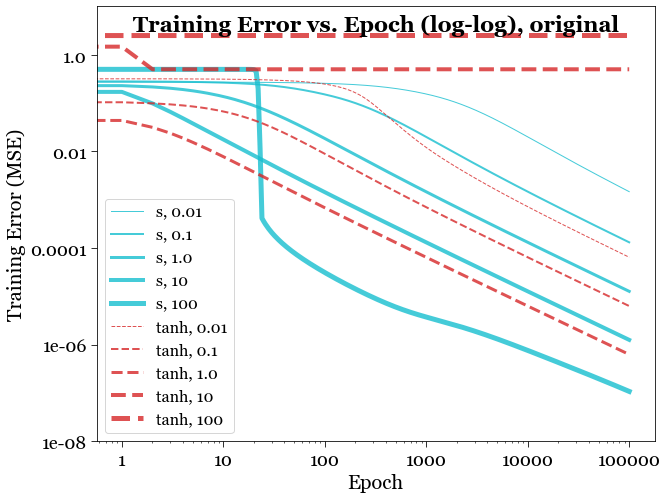

/var/folders/h6/9mpjzmxd77l7493g4210phz00000gn/T/ipykernel_1359/2567063083.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontdict=tick_font)
/var/folders/h6/9mpjzmxd77l7493g4210phz00000gn/T/ipykernel_1359/2567063083.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontdict=tick_font)


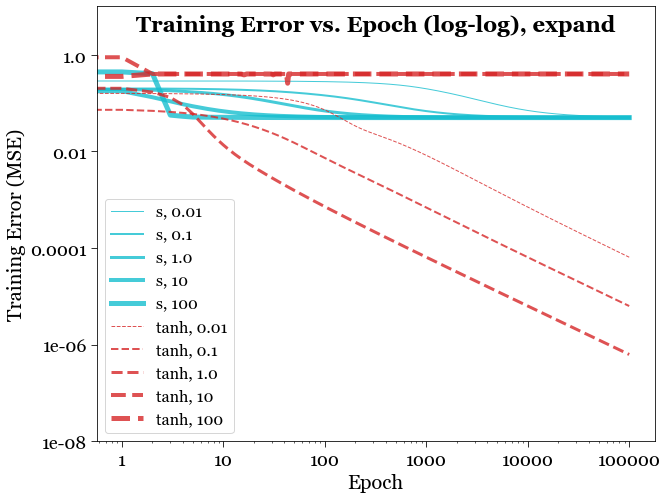

/var/folders/h6/9mpjzmxd77l7493g4210phz00000gn/T/ipykernel_1359/2567063083.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), fontdict=tick_font)
/var/folders/h6/9mpjzmxd77l7493g4210phz00000gn/T/ipykernel_1359/2567063083.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontdict=tick_font)


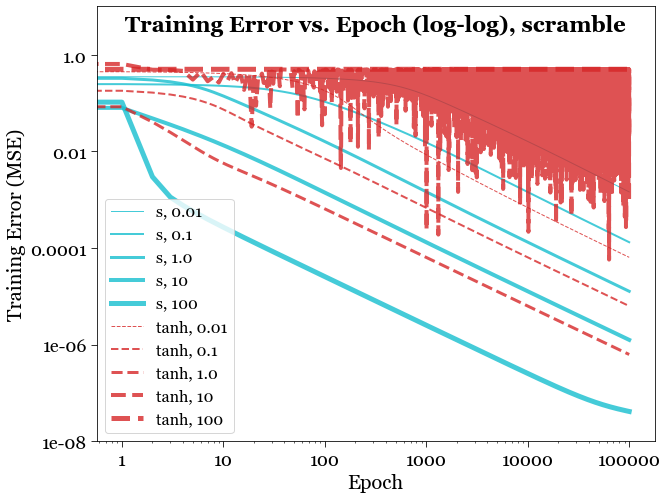

In [14]:
plot_train_data(perceptron_dataset_original, 'original')
plot_train_data(perceptron_dataset_expand, 'expand')
plot_train_data(perceptron_dataset_scramble, 'scramble')

In [23]:
# identify best training hyperparameters
best_train_params_original = {'sigmoid': 100, 'tanh': 1.0}
best_train_params_expand = {'sigmoid': 100, 'tanh': 1.0}
best_train_params_scramble = {'sigmoid': 100, 'tanh': 1.0}

In [26]:
def plot_test_data(perceptron_dataset, best_train_params, y_test, suffix):
    """
    Plot prediction and desired test results for test cases
    """
    for perceptron_data in perceptron_dataset:
        if ((perceptron_data['transfer_function'] == 'sigmoid') and
            (perceptron_data['learning_rate'] == best_train_params['sigmoid'])):
            y_pred_sigmoid = perceptron_data['test_prediction']
        elif ((perceptron_data['transfer_function'] == 'tanh') and
            (perceptron_data['learning_rate'] == best_train_params['tanh'])):
            y_pred_tanh = perceptron_data['test_prediction']
    
    x_inds = list(range(1, len(y_test) + 1))
    fig = plt.figure(figsize=(10, 6))
    ax = plt.gca()

    # Create a side-by-side bar chart
    ax.scatter(x_inds, y_test,
                marker='x', color=tableau_colors[7], s=200,
                alpha=1, label='desired output')
    ax.scatter(x_inds, y_pred_sigmoid,
                marker='s', color=tableau_colors[9], s=40,
                alpha=1, label='sigmoid prediction')
    ax.scatter(x_inds, y_pred_tanh,
                marker='o', color=tableau_colors[3], s=40,
                alpha=1, label='tanh prediction')
    # Customize tick sizes
    ax.tick_params(axis='both', which='major', labelsize=18, length=6)  # Adjust label size and tick length
    # ax.set_ylim(0, 750)
    ax.set_xticks([1, 2, 3, 4])
    ax.set_xticklabels(ax.get_xticks(), fontdict=tick_font)
    ax.set_yticklabels(ax.get_yticks(), fontdict=tick_font)
    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))

    # Customize the plot (optional)
    plt.xlabel('Test Case Index', fontdict=font)
    plt.ylabel('Predicted and Desired Value', fontdict=font)
    plt.gcf().set_facecolor('white')
    fig.suptitle('Test Performance, Equivalence Logic, ' + suffix, fontproperties=suptitle_font, y=0.93)
    # plt.xticks(x, categories)
    plt.legend(loc='lower right', prop=legend_font)

    # Show the plot
    plt.savefig('./plots/test_' + suffix + '.png')
    plt.show()

/var/folders/h6/9mpjzmxd77l7493g4210phz00000gn/T/ipykernel_1359/2568470924.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontdict=tick_font)


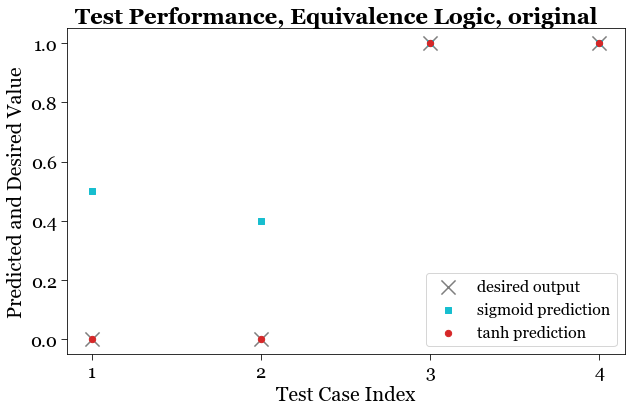

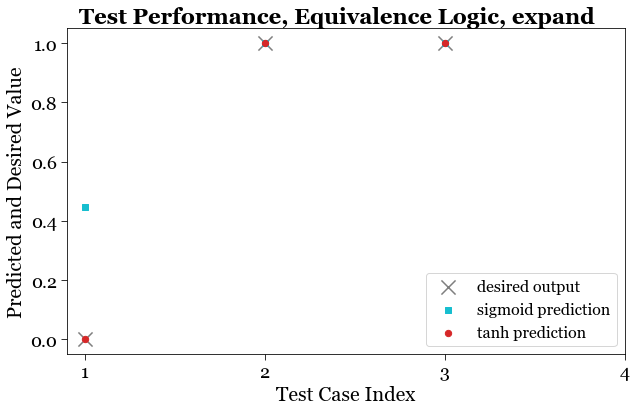

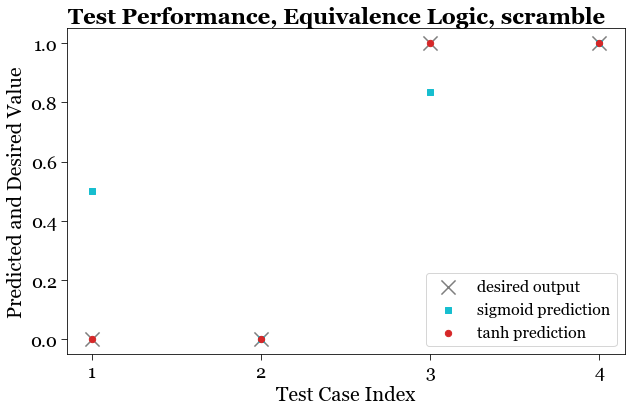

In [27]:
plot_test_data(perceptron_dataset_original, best_train_params_original, 
               y_test_original, 'original')
plot_test_data(perceptron_dataset_expand, best_train_params_expand, 
               y_test_expand, 'expand')
plot_test_data(perceptron_dataset_scramble, best_train_params_scramble, 
               y_test_scramble, 'scramble')

## Double-layer Perceptron for XOR Logic

In [ ]:

for i, tanh_flag in enumerate(tanh_flags):
    for j, learning_rate in enumerate(learning_rates):
        start_time = time.process_time()
        weights[i][j], costs[i][j] = train_perceptron(X_train, y_train, tanh_flag=tanh_flag, eta=learning_rate)
        end_time = time.process_time()
        cpu_times[i][j] = end_time - start_time

        
X_XOR_test = np.array([[0, 0, 0], [0, 1, 0], [1, 0, 0], [1, 1, 0]])
y_XOR_test = np.array([0, 1, 1, 0])
y_XOR_pred_tanh, cost_XOR_tanh = test_perceptron(X_XOR_test, y_XOR_test, weights[1][0], tanh_flag=1)
y_XOR_pred_sigmoid, cost_XOR_sigmoid = test_perceptron(X_XOR_test, y_XOR_test, weights[0][0], tanh_flag=0)
print(y_pred_tanh)
print(y_pred_sigmoid)
print("One can see that neither transfer function yields the right result for XOR.")